## Initial Setup

In [1]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Train

In [72]:
import torch
from importlib import reload
from torch.utils.data import SubsetRandomSampler
from models.type_classifier import TypeClassifier
import models.train
reload(models.train)
from models.train import train, make_batch
import dataloader.ClassificationDataset
reload(dataloader.ClassificationDataset)
from dataloader.ClassificationDataset import ClassificationDataset, AddGaussianNoise
from torchvision import transforms

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [109]:
feature_aug = transforms.Compose([
                transforms.ColorJitter(brightness=[0.8, 1.0], contrast=0, saturation=0, hue=0),
                transforms.RandomAffine(degrees=(0,15), fill=0),
                AddGaussianNoise(0., 0.01),])

In [110]:
dataset = ClassificationDataset(root="/home/janghoon/pneumonia_data", neg_prop=0.5, trans=feature_aug)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.train_idx))
val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.val_idx))
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.test_idx))

In [ ]:
version = "b1"
pretrain_model = TypeClassifier(version=version, num_classes=4).to(device)

optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=1e-5)
loss = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(dataset.get_class_weights()).to(device))
epochs = 10

history = train(pretrain_model, optimizer, train_loader, device, loss, 
                val_dataset=val_loader, epochs=epochs,
                model_dir=f"eagle_eye_models/{version}")

In [111]:
import matplotlib.pyplot as plt

train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


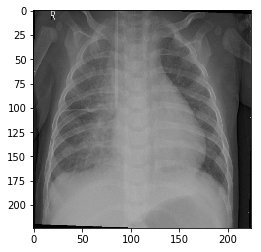

In [119]:
plt.imshow(next(train_iter)["images"][0].numpy().transpose(1,2,0))

## Visualize Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title("Train vs Valid Accuracy")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(np.repeat(np.array(history["val_acc"]), len(train_loader)), label="val_acc")
plt.legend()

plt.figure()
plt.title("Train vs Valid Loss")
plt.plot(history["train_loss"], label="train_loss")
plt.plot(np.repeat(np.array(history["val_loss"]), len(train_loader)), label="val_loss")
plt.legend()

plt.figure()
plt.title("Valid Accuracy vs F1")
plt.plot(np.array(history["val_acc"]), label="val_acc")
plt.plot(np.array(history["val_f1"]), label="val_f1")
plt.legend();
